In [1]:
# Need to set grabcut gamma=5

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import h5py
import time
import pickle
import warnings
import subprocess

from sklearn.decomposition import PCA
from skimage.morphology import convex_hull_image
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from skimage.filters import threshold_otsu, rank
from scipy.ndimage.filters import gaussian_filter, median_filter, maximum_filter, minimum_filter
from scipy.ndimage import grey_closing
from scipy.ndimage import label
from sklearn.metrics import classification_report

from Source.util import getPathsToVisit
from Source.util import getBBox, convex_hull_image3d, fill_holes3d
from Source.util import umtRead, umtWrite
from Source.util import get_first_crossing_time
from Source.ipythonWidgets import overlayViewer, reconViewer

In [4]:
# OpenCV GrabCut constants
GC_BGD = 0
GC_FGD = 1
GC_PR_BGD = 2
GC_PR_FGD = 3

## Load dataset

In [5]:
tic_total = time.time()

In [32]:
pathsToVisit = getPathsToVisit('../Data2')
print('Number of subjects:', len(pathsToVisit))
subjectPath = pathsToVisit[10]
print(subjectPath)
tic = time.time()

# # Load the dataset. (for Data)
# reconPath = os.path.join(subjectPath, 'recon_36p_crop.mat')
# with h5py.File(reconPath) as f:
#     recon = np.array(f['recon']).T
# temp_res = 3.0
# spacing = np.array([1.7, 1.4, 2.4])
# ss_f = [1, 1, 1, 1]
# load_true_labels = True


# # Load the dataset.
# reconPath = os.path.join(subjectPath, 'recon4d_18p.hdf5')
# with h5py.File(reconPath) as f:
#     spacing = np.array(f['spacing'])
#     temp_res = np.array(f['temp_res']).astype(np.float)/1000
#     recon = np.array(f['recon'])
# ss_f = [2, 2, 2, 1]  # Subsampling factor [x,y,z,t]
# load_true_labels = False



# Load the dataset. (for Data2)
reconPath = os.path.join(subjectPath, 'recon4d.hdf5')
with h5py.File(reconPath) as f:
    spacing = np.array(f['spacing'])
    temp_res = np.array(f['temp_res']).astype(np.float)/1000
    recon = np.array(f['recon'])
ss_f = [2, 2, 2, 1]  # Subsampling factor [x,y,z,t]
load_true_labels = True



# # Load the dataset. (for Data3)
# reconPath = os.path.join(subjectPath, 'recon4d.hdf5')
# with h5py.File(reconPath) as f:
#     spacing = np.array(f['spacing'])
#     temp_res = np.array(f['temp_res']).astype(np.float)/1000
#     recon = np.array(f['recon'])
# ss_f = [1, 1, 1, 1]
# load_true_labels = True



recon = recon[::ss_f[0],::ss_f[1],::ss_f[2],::ss_f[3]]
spacing = np.array([ss_f[0],ss_f[1],ss_f[2]])*spacing
nx, ny, nz, nt = recon.shape
print('Elapsed:', time.time()-tic)

Number of subjects: 11
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Data2/11
Elapsed: 37.595415115356445


In [33]:
if issubclass(recon.dtype.type, np.integer):
    recon -= np.amin(recon)
    # Use look up table
    lut = np.arange(np.amax(recon)+1).astype(np.float)
    lut = (lut/np.amax(lut)*255).astype(np.uint8)
    recon = lut[recon]
else:
    recon -= np.amin(recon)
    recon /= np.amax(recon)
    recon = (recon*255).astype(np.uint8)

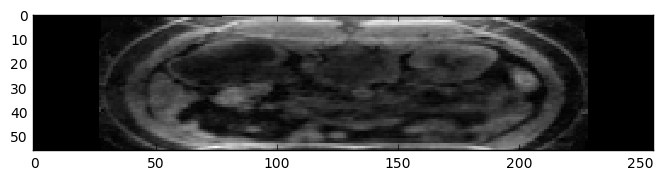

In [34]:
xx = nx//3
tt = 10
im = recon[xx, :, :, tt]
plt.figure(figsize=(8,6))
plt.imshow(im.T, interpolation='none', cmap=plt.cm.gray)

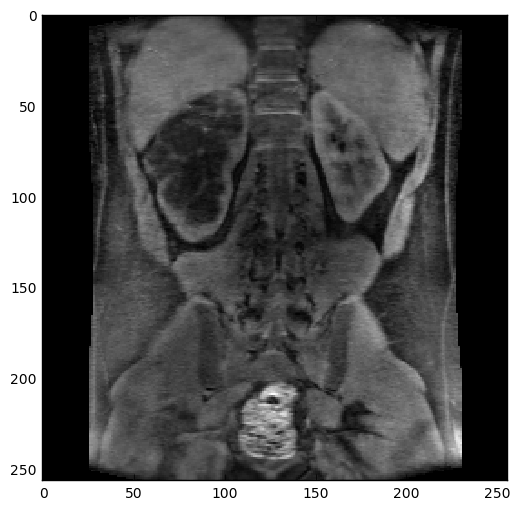

In [35]:
zz = nz//3
tt = 10
im = recon[:, :, zz, tt]
plt.figure(figsize=(8,6))
plt.imshow(im, interpolation='none', cmap=plt.cm.gray)

## Find medulla clusters

In [36]:
cortical_thickness = 11 # mm

10 20 29


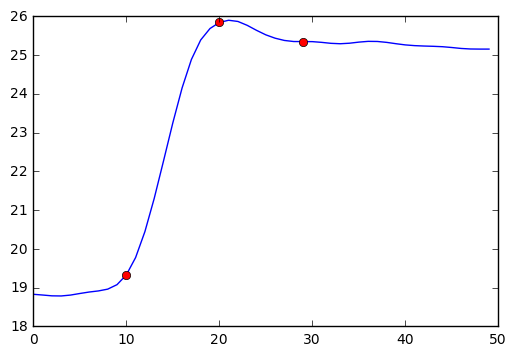

In [37]:
sig = recon.reshape(-1, nt)
mean_sig = np.mean(sig, axis=0)

mean_sig = gaussian_filter(mean_sig, 10/temp_res)

t_5p = get_first_crossing_time(mean_sig, 0.10)[0]
t_5p = np.floor(t_5p).astype(np.int)
t_start = max(t_5p, 0)

t_30 = min(t_start+np.ceil(30/temp_res).astype(np.int), nt-1)
t_45 = min(t_start+np.ceil(45/temp_res).astype(np.int), nt-1)
t_60 = min(t_start+np.ceil(60/temp_res).astype(np.int), nt-1)
t_90 = min(t_start+np.ceil(90/temp_res).astype(np.int), nt-1)
t_120 = min(t_start+np.ceil(120/temp_res).astype(np.int), nt-1)
t_180 = min(t_start+np.ceil(180/temp_res).astype(np.int), nt-1)
t_240 = min(t_start+np.ceil(240/temp_res).astype(np.int), nt-1)
print(t_start, t_60, t_120)

plt.figure()
plt.plot(mean_sig, 'b-')
plt.plot([t_start, t_60, t_120], mean_sig[[t_start, t_60, t_120]], 'ro')

In [38]:
# Penalize voxels with high initial intensity
start_score = recon[:,:,:,t_start].astype(np.float).copy()
start_score = gaussian_filter(start_score, 2/spacing)
start_score -= np.amin(start_score)
start_score /= np.amax(start_score)
start_score = 1 - start_score

In [39]:
overlayViewer(recon, start_score, zz=nz//4, tt=nt//2)

In [40]:
# Penalize voxels where motion is dominant
y = sig[:,t_60:t_120].astype(np.float).T
x = np.arange(y.shape[0])
Z = np.polyfit(x, y, 2)
X = np.vstack((x**2, x**1, x**0))
y_fit = np.dot(Z.T, X)
y_res = y.T-y_fit
y_res_std = np.std(y_res, axis=1)
y_res_std3d = y_res_std.reshape(nx, ny, nz)

In [41]:
motion_score = y_res_std3d.copy()
motion_score = gaussian_filter(motion_score, 2/spacing)
motion_score -= np.amin(motion_score)
motion_score /= np.amax(motion_score)
motion_score = 1 - motion_score

In [42]:
overlayViewer(recon, motion_score, zz=nz//4, tt=nt//2)

In [43]:
# # An example of motion detection (Data k=3)
# plt.figure()
# plt.plot(recon[15,125,27,t_split:])
# plt.plot(recon[55,130,27,t_split:])

# y1 = recon[15,125,27,t_split:]
# y2 = recon[55,130,27,t_split:]
# y = np.vstack((y1, y2)).T
# x = np.arange(y.shape[0])
# z = np.polyfit(x,y,2)

# X = np.vstack((x**2, x**1, x**0))

# P = np.dot(z.T, X)

# p1 = np.poly1d(z[:,0])
# p2 = np.poly1d(z[:,1])
# plt.plot(x, P[0,:])
# plt.plot(x, P[1,:])

# plt.figure()
# plt.plot(y1-P[0,:])
# plt.plot(y2-P[1,:])

# # Look compare the std to identify the moving voxels

In [44]:
# Look at time to peak
im_90p = get_first_crossing_time(recon[:,:,:,t_start:t_60], 0.90)
im_90p[im_90p==0.0] = np.amax(im_90p)
im_90p = gaussian_filter(im_90p, sigma=2/spacing)
im_90p -= np.amin(im_90p)
im_90p /= np.amax(im_90p)
im_90p = 1 - im_90p

In [45]:
nb_mm = cortical_thickness
nb = np.ceil(nb_mm/spacing).astype(np.int)
print(nb)

im_90p_filt = im_90p.copy()
im_90p_filt = maximum_filter(im_90p_filt, nb)
im_90p_filt = minimum_filter(im_90p_filt, nb)
med_temp_score = im_90p_filt

[8 8 4]


In [46]:
overlayViewer(recon, im_90p_filt, zz=nz//4, tt=nt//2)

In [47]:
recon_bl = gaussian_filter(recon.astype(np.float), np.hstack((0/spacing, 10/temp_res)))
recon_start = recon_bl[:,:,:,t_start].astype(np.float)
recon_30 = recon_bl[:,:,:,t_30].astype(np.float)
recon_45 = recon_bl[:,:,:,t_45].astype(np.float)
recon_60 = recon_bl[:,:,:,t_60].astype(np.float)
recon_90 = recon_bl[:,:,:,t_90].astype(np.float)
recon_120 = recon_bl[:,:,:,t_120].astype(np.float)
recon_240 = recon_bl[:,:,:,t_240].astype(np.float)

In [48]:
med_marker3_1 = (recon_60-recon_start)
med_marker3_1[med_marker3_1 < 0] = 0
med_marker3_1 = gaussian_filter(med_marker3_1, 2/spacing)
med_marker3_1 -= np.amin(med_marker3_1)
med_marker3_1 /= np.amax(med_marker3_1)

med_marker3_2 = (recon_120 - recon_60)
mask = med_marker3_2 > 0
med_marker3_2[med_marker3_2 < 0] = 0
med_marker3_2 = gaussian_filter(med_marker3_2, 2/spacing)
med_marker3_2 -= np.amin(med_marker3_2)
med_marker3_2 /= np.amax(med_marker3_2)

med_marker3 = np.ones((nx, ny, nz), dtype=np.float)
med_marker3 = med_marker3 * med_marker3_1
med_marker3 = med_marker3 * med_marker3_2
med_marker3 = med_marker3 * motion_score
med_marker3 = med_marker3 * start_score
med_marker3 = med_marker3 * med_temp_score
med_marker3 = med_marker3/np.amax(med_marker3)

med_marker3[med_marker3 < 0] = 0
med_marker_filt3 = med_marker3*mask

In [49]:
overlayViewer(recon, med_marker_filt3, zz=nz//3, tt=nt//2)

In [50]:
if (t_180 < nt-1):
    # Look at time to peak
    cs_im_90 = get_first_crossing_time(recon[:,:,:,t_start:t_180], 0.90)
    cs_im_90 = gaussian_filter(cs_im_90, sigma=2/spacing)
    cs_im_90 -= np.amin(cs_im_90)
    cs_im_90 /= np.amax(cs_im_90)
    cs_temp_score = cs_im_90
    
    overlayViewer(recon, cs_temp_score, zz=nz//4, tt=nt//2)

In [51]:
if (t_180 < nt-1):

    med_marker4_2 = (recon_240 - recon_120)
    mask = med_marker4_2 > 0
    med_marker4_2[med_marker4_2 < 0] = 0
    med_marker4_2 = gaussian_filter(med_marker4_2, 2/spacing)
    med_marker4_2 -= np.amin(med_marker4_2)
    med_marker4_2 /= np.amax(med_marker4_2)

    med_marker4 = np.ones((nx, ny, nz), dtype=np.float)
    med_marker4 = med_marker4 * med_marker4_2
    med_marker4 = med_marker4 * motion_score
    med_marker4 = med_marker4 * start_score
    med_marker4 = med_marker4 * cs_temp_score
    med_marker4 = med_marker4/np.amax(med_marker4)

    med_marker4[med_marker4 < 0] = 0
    med_marker_filt4 = med_marker4*mask

In [52]:
if (t_180 < nt-1):
    med_marker5 = med_marker4/np.amax(med_marker4) + med_marker_filt3/np.amax(med_marker_filt3)
    med_marker_filt5 = med_marker_filt4/np.amax(med_marker_filt4) + med_marker_filt3/np.amax(med_marker_filt3)
else:
    med_marker_filt5 = med_marker_filt3

In [53]:
overlayViewer(recon, med_marker_filt5, zz=nz//3)

In [54]:
med_marker_im3d = med_marker_filt5.copy()
med_marker_im3d -= np.amin(med_marker_im3d)
med_marker_im3d /= np.amax(med_marker_im3d)
med_marker_im3d = (255*med_marker_im3d).astype(np.uint8)

In [55]:
med_cutoff_otsu = threshold_otsu(med_marker_im3d[med_marker_im3d>0].ravel())

In [56]:
overlayViewer(recon, med_marker_im3d.astype(np.float), th=med_cutoff_otsu, zz=nz//3, tt=nt//2)

In [57]:
# marker = med_marker_im3d.astype(np.float).copy()
# marker[57,122,34] = np.amax(marker)
# overlayViewer(recon, marker, th=med_cutoff_otsu, zz=34, tt=nt//2)

In [58]:
# plt.figure()
# plt.plot(recon[76,145,34,:])
# plt.plot(recon[100,155,24,:])
# plt.plot(recon[57,122,35,:])

In [59]:
nb_mm = cortical_thickness
nb = np.ceil(nb_mm/spacing).astype(np.int)
print(nb)

med_valid = med_marker_im3d.astype(np.float) > med_cutoff_otsu

med_valid_max = maximum_filter(med_valid, nb)
med_valid_label, num_labels = label(med_valid_max)
med_valid_label[med_valid==0] = 0

[8 8 4]


In [60]:
overlayViewer(recon, med_valid_max, zz=nz//3, tt=nt//2)

In [61]:
if load_true_labels:
    # Load true cortex labels
    labels_path = os.path.join(subjectPath, 'labels.hdf5')
    with h5py.File(labels_path) as f:
        labels_kidney3d = np.array(f['labels'])
    
    # Apply subsampling
    labels_kidney3d = labels_kidney3d[::ss_f[0],::ss_f[1],::ss_f[2]]

    # Ignore medulla and collecting system that fall outside of the convex hull.
    labels_kidney3d[labels_kidney3d > 3] = 0
    
    # Generate the convex hull for the kidneys
    for cluster_id in [2, 3]:
        cluster = labels_kidney3d == cluster_id
        for zz in range(cluster.shape[2]):
            bm = cluster[:,:,zz]
            if np.sum(bm) == 0:
                continue
            bm = convex_hull_image(bm)
            cluster[:,:,zz] = bm > 0
        labels_kidney3d[cluster > 0] = cluster_id

In [62]:
cluster_size = np.bincount(med_valid_label.ravel())
print(cluster_size)
cluster_size[0] = 0
sorted_clusters = np.argsort(cluster_size)[::-1]
print(sorted_clusters)
largest_n = 4
med_valid_largest = np.zeros_like(med_valid_label)
for i in range(min(largest_n, sorted_clusters.shape[0])):
    cluster_id = sorted_clusters[i]
    if cluster_size[cluster_id] > 0:
        med_valid_largest[med_valid_label == cluster_id] = i+1

[3653421   11575    3946       4       5     226      25     176       9
       4     362       2     261]
[ 1  2 10 12  5  7  6  8  4  9  3 11  0]


In [63]:
overlayViewer(recon, med_valid_largest, zz=nz//3, tt=nt//2)

In [64]:
#nb_mm = 25 # Based on cortical thickness (12.5 mm extension on all sides for max cort. thickness of 11mm)
nb_mm = 2*(cortical_thickness*1.15)
nb = np.ceil(nb_mm/spacing).astype(np.int)
print(nb)

# Process each region separately
bbox_list = []
potential_mask_bbox_list = []
for cluster_id in np.unique(med_valid_largest[med_valid_largest > 0]):
    # Expand the mask by maximum cortical thickness to cover the whole kidney
    potential_mask = med_valid_largest == cluster_id
    potential_mask = maximum_filter(potential_mask, nb)
    
    # Generate the 3d convex hull
    potential_mask = convex_hull_image3d(potential_mask)
    
    # Calculate the bounding box
    bbox = getBBox(potential_mask)
    
    # Expand bbox to get more background
    scale = 1.5
    xyz_min, xyz_end = bbox
    xyz_len = xyz_end-xyz_min
    xyz_len_shift = np.round((scale-1)*xyz_len).astype(np.int)
    new_xyz_min = xyz_min - np.floor(xyz_len_shift/2).astype(np.int)
    new_xyz_min[new_xyz_min < 0] = 0
    new_xyz_len = xyz_len + xyz_len_shift
    new_xyz_max = new_xyz_min + new_xyz_len
    new_xyz_over = new_xyz_max - [nx,ny,nz]
    new_xyz_over[new_xyz_over < 0] = 0
    new_xyz_len = xyz_len + xyz_len_shift - new_xyz_over
    bbox = (new_xyz_min, new_xyz_min + new_xyz_len)
    bbox_list.append(bbox)
    
    # Store potential_mask 
    bb_l, bb_h = bbox
    potential_mask_bbox = potential_mask[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]]
    potential_mask_bbox_list.append(potential_mask_bbox)

[18 18  9]


In [65]:
# Create potential_mask3d for visualization
potential_mask3d = np.zeros((nx, ny, nz), dtype=np.int)
for i in range(len(bbox_list)):
    bbox = bbox_list[i]
    bb_l, bb_h = bbox
    potential_mask_bbox = potential_mask_bbox_list[i].astype(np.int)
    potential_mask3d_slice = potential_mask3d[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]]
    potential_mask3d_slice[potential_mask_bbox > 0] = i+1

In [66]:
overlayViewer(recon, potential_mask3d, zz=nz//3, tt=nt//2)

In [67]:
recon_min = np.amin(recon, axis=3, keepdims=True)
recon_diff = gaussian_filter(recon - recon_min, np.hstack((0/spacing, 0/temp_res)))

im3d_pca_bbox_list = []
im3d_rgb_bbox_list = []
for i in range(len(bbox_list)):
    bbox = bbox_list[i]
    bb_l, bb_h = bbox
    recon_diff_bbox = recon_diff[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2], :]
    nx_bb, ny_bb, nz_bb, nt_bb = recon_diff_bbox.shape
    pca = PCA(n_components=3)
    im3d_pca_bbox = pca.fit_transform(recon_diff_bbox.reshape(-1, recon_diff_bbox.shape[-1]).astype(np.float))
    im3d_pca_bbox = im3d_pca_bbox.reshape(nx_bb, ny_bb, nz_bb, -1)
    im3d_pca_bbox_list.append(im3d_pca_bbox)
    im3d_rgb_bbox = im3d_pca_bbox.copy()
    for ch in range(im3d_rgb_bbox.shape[3]):
        im3d_ch = im3d_rgb_bbox[:,:,:,ch]
        im3d_ch -= np.amin(im3d_ch)
        im3d_ch = im3d_ch/np.amax(im3d_ch)*255
        im3d_rgb_bbox[:,:,:,ch] = im3d_ch
    im3d_rgb_bbox = im3d_rgb_bbox.astype(np.uint8)
    im3d_rgb_bbox_list.append(im3d_rgb_bbox)

In [68]:
output3d = np.zeros(potential_mask3d.shape, dtype=np.int)
output3d_bbox_list = []
for i in range(len(bbox_list)):
    bbox = bbox_list[i]
    bb_l, bb_h = bbox
    
    im3d_rgb_bbox = im3d_rgb_bbox_list[i]
    potential_mask3d_bbox = potential_mask_bbox_list[i]
    
    img_gc = np.transpose(im3d_rgb_bbox, (2, 0, 1, 3))

    mask_gc = np.zeros(im3d_rgb_bbox.shape[:3], np.uint8)
    mask_gc[potential_mask3d_bbox > 0] = GC_PR_FGD
    mask_gc = np.transpose(mask_gc, (2, 0, 1))

    input_filename = os.path.join(os.getcwd(), "Buffer", "input.umt")
    mask_filename = os.path.join(os.getcwd(), "Buffer", "mask.umt")
    output_filename = os.path.join(os.getcwd(), "Buffer", "output.umt")
    print(input_filename)
    print(mask_filename)
    print(output_filename)
    umtWrite(input_filename, img_gc)
    umtWrite(mask_filename, mask_gc)
    
    program_path = os.path.join(os.getcwd(), "CppSource", "DisplayMat", "run_grabcut3d")
    tic = time.time()
    ret_val = subprocess.call([program_path, input_filename, mask_filename, output_filename])
    print('Returned', ret_val)
    print('Elapsed time:', time.time()-tic)
    
    output3d_bbox = umtRead(output_filename)
    output3d_bbox = np.transpose(output3d_bbox, (1, 2, 0)) == GC_PR_FGD
    output3d_bbox_list.append(output3d_bbox)
    
    output3d_slice = output3d[bb_l[0]:bb_h[0], bb_l[1]:bb_h[1], bb_l[2]:bb_h[2]]
    output3d_slice[output3d_bbox > 0] = output3d_bbox[output3d_bbox > 0]

/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/input.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/mask.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/output.umt
Returned 0
Elapsed time: 9.60443115234375
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/input.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/mask.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/output.umt
Returned 0
Elapsed time: 10.546889066696167
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/input.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/mask.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/output.umt
Returned 0
Elapsed time: 0.73996901512146
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/input.umt
/Users/umityoruk/Documents/PythonDev/NewSegmentation/Notebook/Buffer/mask.umt
/Use

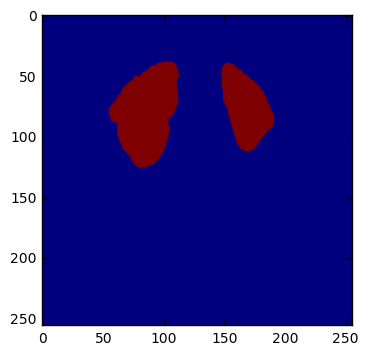

In [69]:
plt.figure()
plt.imshow(output3d[:,:,nz//3])

In [70]:
kidney_labels, n_labels = label(output3d)
cluster_size = np.bincount(kidney_labels.ravel())
print(cluster_size[1:])

# Eliminate anything below 25% of the largest region
cluster_size[0] = 0
cluster_size_cutoff = np.amax(cluster_size)*0.25
cluster_size[cluster_size < cluster_size_cutoff] = 0
cluster_id = 0
for i in range(n_labels+1):
    if cluster_size[i] > 0:
        cluster_id += 1
        cluster_size[i] = cluster_id
kidney_labels = cluster_size[kidney_labels]

cluster_size = np.bincount(kidney_labels.ravel())
print(cluster_size[1:])

[28589 45695     1   412]
[28589 45695]


In [71]:
overlayViewer(recon, kidney_labels, zz=nz//3, tt=nt//2)
# overlayViewer(recon, im3d_rgb[:,:,:,0]*(kidney_labels>0))

In [72]:
# crop_x = [50, 150]
# crop_y = [50, 200]

# zz = 19
# tt = 49
# overlay_im = kidney_labels[:,:,zz].copy()
# o_min = np.amin(overlay_im)
# o_max = np.amax(overlay_im)

# overlay_im = overlay_im[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]]

# overlay_mask = np.ma.masked_where(overlay_im <= 0, overlay_im)
# im = recon[:,:,zz,tt]

# im = im[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]]


# plt.figure(figsize=(8,6))
# plt.imshow(im, interpolation='none', cmap=plt.cm.gray)
# plt.imshow(overlay_mask, interpolation='none', cmap=plt.cm.jet, vmin=o_min, vmax=o_max, alpha=0.0)
# plt.gca().xaxis.set_visible(False)
# plt.gca().yaxis.set_visible(False)
# save_format = ['svg', 'pdf']
# for ext in save_format:
#     filename = os.path.join('/Users/umityoruk/Desktop/', 'fail0' + '.' + ext)
#     plt.savefig(filename, bbox_inches='tight')

In [73]:
if load_true_labels:
    # Generate the convex hull for the kidney_labels
    kidney_labels_hull = kidney_labels.copy()
    for cluster_id in range(1, np.amax(kidney_labels_hull)+1):
        cluster = kidney_labels_hull == cluster_id
        for zz in range(cluster.shape[2]):
            bm = cluster[:,:,zz]
            if np.sum(bm) == 0:
                continue
            bm = convex_hull_image(bm)
            cluster[:,:,zz] = bm > 0
        kidney_labels_hull[cluster > 0] = cluster_id
    print(classification_report(labels_kidney3d.ravel()>1, kidney_labels_hull.ravel()>0))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   3578615
       True       0.97      0.86      0.91     91401

avg / total       1.00      1.00      1.00   3670016



In [74]:
if load_true_labels:
    overlayViewer(labels_kidney3d > 1, kidney_labels_hull, oa=0.8)

In [230]:
print('First Pass Elapsed:', time.time()-tic_total)

First Pass Elapsed: 1876.1094739437103


## 3D Clean Up

In [231]:
from scipy.ndimage.morphology import binary_fill_holes

def fill_holes3d(im3d):
    nx, ny, nz = im3d.shape
    out3d = im3d.copy()
    while True:
        sum_prev = np.sum(out3d)
        for xx in range(nx):
            bm = out3d[xx,:,:]
            if not np.any(bm):
                continue
            out3d[xx,:,:] = binary_fill_holes(bm)
        for yy in range(ny):
            bm = out3d[:,yy,:]
            if not np.any(bm):
                continue
            out3d[:,yy,:] = binary_fill_holes(bm)
        for zz in range(nz):
            bm = out3d[:,:,zz]
            if not np.any(bm):
                continue
            out3d[:,:,zz] = binary_fill_holes(bm)
        sum_current = np.sum(out3d)
        progress = sum_current-sum_prev
        print(progress)
        if progress == 0:
            break
    return out3d

In [232]:
# Fill holes in x, y, z slices for robustness
# This will fill up the convex volume before erosion.
output_filled = fill_holes3d(output3d)

1259
31
0


In [233]:
overlayViewer(recon, output_filled)

In [234]:
nb_mm = 3.2*2 # (2 x minimum cortical thickness)
nb = np.floor(nb_mm/spacing).astype(np.int) # (floor to be conservative)
nb[nb<3] = 3 # At least 1 voxel in each direction
print(nb)

# Erode the output of the first pass
# output3d_eroded = minimum_filter(output3d, nb)
output3d_eroded = minimum_filter(output_filled, nb)
output3d_opened = maximum_filter(output3d_eroded, nb+2)

[3 4 3]


In [235]:
output3d_cleaned = output3d.copy()
output3d_cleaned[output3d_opened > 0] = 0

In [236]:
overlayViewer(recon, output3d_cleaned, zz=26, tt=nt//2)

In [237]:
# Alternative to second pass
output3d_final2 = output3d.copy()
output3d_final2[output3d_opened == 0] = 0

In [238]:
kidney_labels, n_labels = label(output3d_final2)
cluster_size = np.bincount(kidney_labels.ravel())
print(cluster_size[1:])

# Eliminate anything below 25% of the largest region
cluster_size[0] = 0
cluster_size_cutoff = np.amax(cluster_size)*0.25
cluster_size[cluster_size < cluster_size_cutoff] = 0
cluster_id = 0
for i in range(n_labels+1):
    if cluster_size[i] > 0:
        cluster_id += 1
        cluster_size[i] = cluster_id
kidney_labels = cluster_size[kidney_labels]

cluster_size = np.bincount(kidney_labels.ravel())
print(cluster_size[1:])

[17607 12460]
[17607 12460]


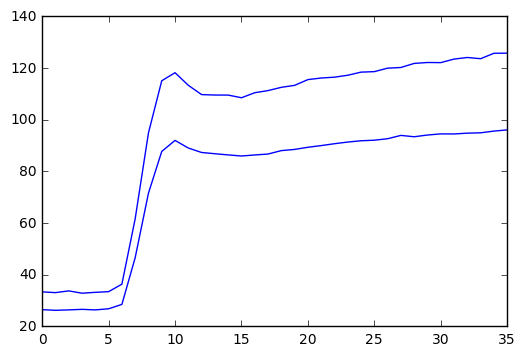

In [239]:
# Get rid of noisy regions
sig = recon.reshape(-1, nt)
kidney_labels_fixed = np.zeros_like(kidney_labels)
valid_count = 0
valid_sig = []
invalid_sig = []
for cluster_id in np.unique(kidney_labels[kidney_labels > 0]):
    cluster_mask = kidney_labels == cluster_id
    sig_mask = np.mean(sig[cluster_mask.ravel(), :], axis=0)
    t_50p = get_first_crossing_time(sig_mask.reshape(1, -1), 0.50)
    if t_50p < t_start or t_50p > t_30:
        print('Noise_detected!')
        invalid_sig.append(sig_mask)
        continue
    valid_sig.append(sig_mask)
    valid_count += 1
    kidney_labels_fixed[cluster_mask > 0] = valid_count
    

plt.figure()
if len(valid_sig) > 0:
    valid_sig = np.vstack(valid_sig)
    plt.plot(valid_sig.T, 'b-')
if len(invalid_sig) > 0:
    invalid_sig = np.vstack(invalid_sig)
    plt.plot(invalid_sig.T, 'r-')

In [240]:
kidney_labels = kidney_labels_fixed

In [241]:
# Generate the convex hull for the kidney_labels
kidney_labels_hull = kidney_labels.copy()
for cluster_id in range(1, np.amax(kidney_labels_hull)+1):
    cluster = kidney_labels_hull == cluster_id
    for zz in range(cluster.shape[2]):
        bm = cluster[:,:,zz]
        if np.sum(bm) == 0:
            continue
        bm = convex_hull_image(bm)
        cluster[:,:,zz] = bm > 0
    kidney_labels_hull[cluster > 0] = cluster_id
        
if load_true_labels:
    print(classification_report(labels_kidney3d.ravel()>1, kidney_labels_hull.ravel()>0))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   3422093
       True       0.97      0.98      0.97     33907

avg / total       1.00      1.00      1.00   3456000



In [242]:
overlayViewer(recon, kidney_labels, zz=nz//3, tt=nt//2)

In [243]:
# outputPath = os.path.join(subjectPath, 'gc_labels.hdf5')
# with h5py.File(outputPath, 'w') as f:
#     dset = f.create_dataset('gc_labels', data=kidney_labels, compression='gzip')

In [244]:
print('Renal Segmentation Elapsed:', time.time()-tic_total)

Renal Segmentation Elapsed: 1885.209506034851
